In [1]:
# ─────────────────────────────────────────────────────────────
# Cell 1 – imports & basic setup
# ─────────────────────────────────────────────────────────────
import copy, sys, logging
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scripts.data_handling.build_inputs import build_all
from config.default_config import DEFAULT_CONFIG
from scripts.tephra_inversion import TephraInversion

plt.style.use("seaborn-v0_8")
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().system('tree -L 3')

.
├── config
│   ├── default_config.py
│   └── __pycache__
│       └── default_config.cpython-310.pyc
├── core.5311
├── core.5584
├── core.5740
├── core.5786
├── core.5863
├── data
│   ├── input
│   │   ├── esp_input.csv
│   │   ├── observations.csv
│   │   ├── sites.csv
│   │   ├── tephra2.conf
│   │   ├── tephra2_output_mcmc.txt
│   │   └── wind.txt
│   └── output
├── demo.ipynb
├── demo_new.ipynb
├── example.ipynb
├── node_
├── plume2.dat
├── README.md
├── requirements.txt
├── scripts
│   ├── core
│   │   ├── lhs.py
│   │   ├── mcmc.py
│   │   ├── mcmc_utils.py
│   │   ├── __pycache__
│   │   └── tephra2_interface.py
│   ├── data_handling
│   │   ├── build_inputs.py
│   │   ├── coordinate_utils.py
│   │   ├── esp_config.py
│   │   ├── observation_data.py
│   │   ├── __pycache__
│   │   └── wind_data.py
│   ├── __pycache__
│   │   └── tephra_inversion.cpython-310.pyc
│   ├── tephra_inversion.py
│   └── visualization
│       ├── diagnostic_plots.py
│       ├── observation_plots.py
│  

In [2]:
# ─────────────────────────────────────────────────────────────
# Cell 2 – generate the two Tephra2 input files
# ─────────────────────────────────────────────────────────────
vent_lat, vent_lon, vent_elev = 31.9, 130.9, 1000

build_all(
    vent_lat  = vent_lat,
    vent_lon  = vent_lon,
    vent_elev = vent_elev,
    plume_height  = 10_000,
    eruption_mass = 2.5e10
)

tephra2.conf written → data/input/tephra2.conf
esp_input.csv written → data/input/esp_input.csv
[INFO] Input bundle ready.


In [3]:
# ─────────────────────────────────────────────────────────────
# Cell 3 – wrap observations + sites into one DataFrame
# ─────────────────────────────────────────────────────────────
obs_vec  = np.loadtxt("data/input/observations.csv")          # 1-D array

sites_ar = pd.read_csv("data/input/sites.csv", sep=r"\s+", header=None).values

obs_df = pd.DataFrame({
    "easting":      sites_ar[:, 0],
    "northing":     sites_ar[:, 1],
    "elevation":    sites_ar[:, 2],
    "observation":  obs_vec,
})

obs_df

,easting,northing,elevation,observation
0,691998.0,3520374.0,1000.0,10.00
1,688621.0,3522661.0,1000.0,18.00
2,685128.0,3524972.0,1000.0,15.00
3,682997.0,3529018.0,1000.0,51.00
4,682918.0,3528234.0,1000.0,55.33
...,...,...,...,...
58,682730.0,3528208.0,1000.0,50.00
59,685508.0,3529620.0,1000.0,20.00
60,685518.0,3529780.0,1000.0,18.00
61,697972.0,3527237.0,1000.0,1.00


In [4]:
# ─────────────────────────────────────────────────────────────
# Cell 4 – build a minimal config (plume_height & ln(mass) free)
# ─────────────────────────────────────────────────────────────
cfg = copy.deepcopy(DEFAULT_CONFIG)
cfg["parameters"] = {                         # 2 free + 3 fixed
    "plume_height": {
        "initial_value": 10000,
        "prior_type":    "Gaussian",
        "prior_mean":    10000,
        "prior_std":     2000,
        "draw_scale":    20,
    },
    "log_mass": {
        "initial_value": np.log(2.5e10),      # natural log
        "prior_type":    "Gaussian",
        "prior_mean":    np.log(2.5e10),
        "prior_std":     1,
        "draw_scale":    0.1,
    },
    "vent_easting":   {"initial_value": sites_ar[0,0], "prior_type":"Fixed", "draw_scale":""},
    "vent_northing":  {"initial_value": sites_ar[0,1], "prior_type":"Fixed", "draw_scale":""},
    "vent_elevation": {"initial_value": vent_elev,     "prior_type":"Fixed", "draw_scale":""},
}

In [5]:
# ─────────────────────────────────────────────────────────────
# Cell 5 – run the inversion
# ─────────────────────────────────────────────────────────────
inv = TephraInversion(cfg, observations=obs_df)

inv.config["mcmc"]["n_iterations"] = 1000   # quick demo
inv.config["mcmc"]["n_burnin"]     = 200
inv.config["mcmc"]["silent"] = False

results = inv.run_inversion()
burnin  = inv.config["mcmc"]["n_burnin"]

2025-04-28 10:22:45,792 - root - INFO - TephraInversion initialized
2025-04-28 10:22:45,793 - root - INFO - Using config file: data/input/tephra2.conf
2025-04-28 10:22:45,794 - root - INFO - Using sites file: data/input/sites.csv
2025-04-28 10:22:45,794 - root - INFO - Using wind file: data/input/wind.txt
2025-04-28 10:22:45,795 - root - INFO - Output will be written to: data/output/tephra2_output_mcmc.txt
2025-04-28 10:22:45,799 - root - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC: 100%|██████████| 1000/1000 [02:20<00:00,  7.10it/s, acc=0.569, lnM=23.1, plume=6.97e+3]

2025-04-28 10:25:06,748 - root - INFO - MCMC finished: 1000 iters, accept=0.57


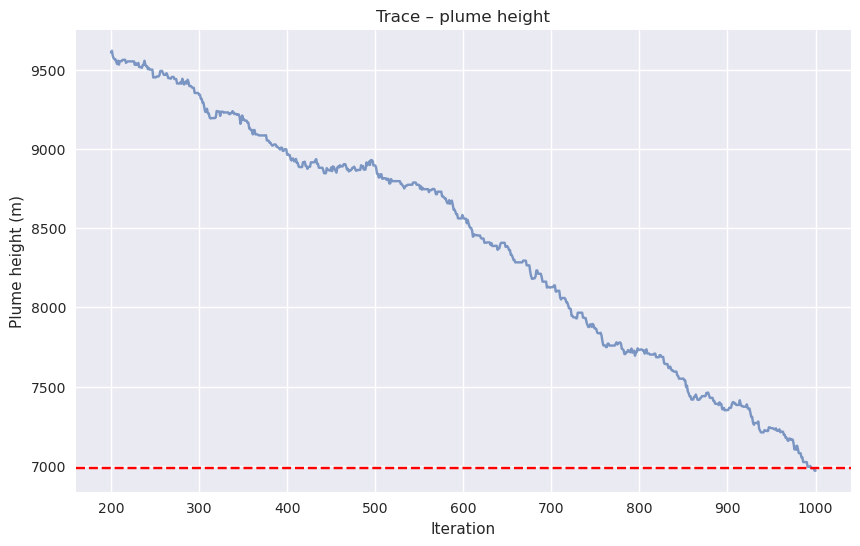

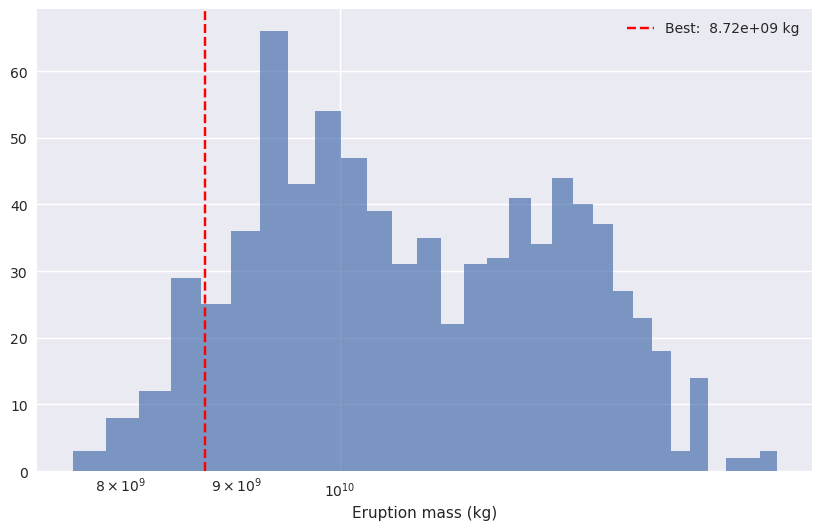

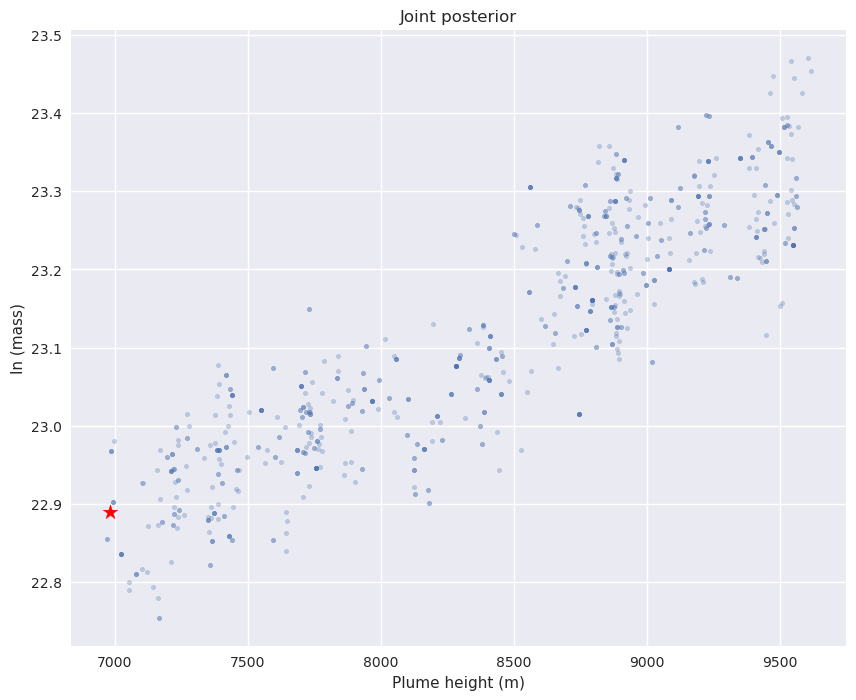

In [6]:
# ─────────────────────────────────────────────────────────────
# Cell 6 – plots (now using np.exp for mass)
# ─────────────────────────────────────────────────────────────
plt.figure(figsize=(10,6))
plt.plot(results["chain"]["plume_height"][burnin:], alpha=.7)
plt.axhline(results["best_params"]["plume_height"], color='r', ls='--')
plt.xlabel("Iteration"); plt.ylabel("Plume height (m)")
plt.title("Trace – plume height"); plt.grid(True); plt.show()

plt.figure(figsize=(10,6))
mass_vals = np.exp(results["chain"]["log_mass"][burnin:])
best_mass = np.exp(results["best_params"]["log_mass"])
plt.hist(mass_vals, bins=30, alpha=.7)
plt.axvline(best_mass, color='r', ls='--',
            label=f"Best: {best_mass: .2e} kg")
plt.xlabel("Eruption mass (kg)"); plt.xscale("log"); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,8))
plt.scatter(results["chain"]["plume_height"][burnin:],
            results["chain"]["log_mass"][burnin:], s=10, alpha=.3)
plt.scatter(results["best_params"]["plume_height"],
            results["best_params"]["log_mass"],
            color='red', s=120, marker='*')
plt.xlabel("Plume height (m)"); plt.ylabel("ln (mass)")
plt.title("Joint posterior"); plt.grid(True); plt.show()

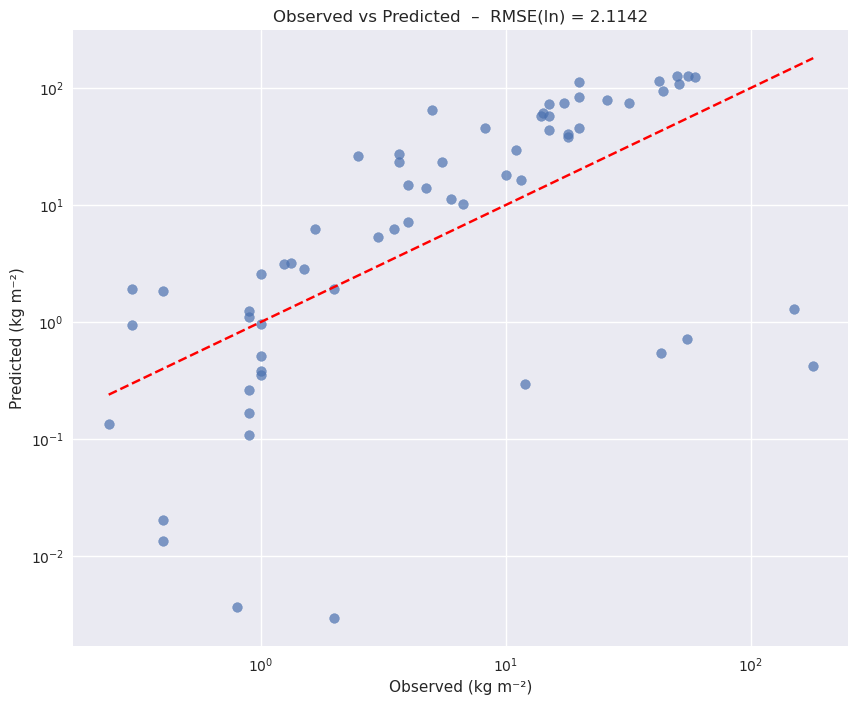

Plume height (best) : 6983.7 m
Eruption mass (best): 8.72e+09 kg
Acceptance rate     : 0.57
RMSE (ln)           : 2.1142


In [7]:
# ─────────────────────────────────────────────────────────────
# Cell 7 – residuals & summary
# ─────────────────────────────────────────────────────────────
# 1) run Tephra2 once with the best parameters
from scripts.core.mcmc import run_tephra2
best_vec = results["best_params"].values          # DataFrame row → 1-D array
pred = run_tephra2(
    plume_vec = best_vec,
    conf_path = Path("data/input/tephra2.conf"),
    sites_csv = Path("data/input/sites.csv"),
    silent    = True
)

# 2) RMSE in natural-log space
rmse_ln = np.sqrt(((np.log(obs_vec) - np.log(pred))**2).mean())

# 3) scatter plot
plt.figure(figsize=(10,8))
plt.scatter(obs_vec, pred, alpha=.7)
lims = [obs_vec.min(), obs_vec.max()]
plt.plot(lims, lims, 'r--')
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Observed (kg m⁻²)"); plt.ylabel("Predicted (kg m⁻²)")
plt.title(f"Observed vs Predicted  –  RMSE(ln) = {rmse_ln:.4f}")
plt.grid(True); plt.show()

# 4) text summary
best_mass = np.exp(results["best_params"]["log_mass"])
print(f"Plume height (best) : {results['best_params']['plume_height']:.1f} m")
print(f"Eruption mass (best): {best_mass:.2e} kg")
print(f"Acceptance rate     : {results['acceptance_rate']:.2f}")
print(f"RMSE (ln)           : {rmse_ln:.4f}")
